In [1]:
import os
import cv2 
import tensorflow as tf 
import numpy as np 
from typing import List
from matplotlib import pyplot as plt 
import imageio

In [3]:
phys = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(phys[0], True)
except:
    pass

Data loading functions to preprocess the videos and annotations

In [79]:
def load_video(path:str)->List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    #store all frames
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #isolate mouth region 
        # (im not going to use a dlib mouth extractor sorry)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    #mean and std of the frames
    mean = tf.math.reduce_mean(tf.cast(frames, tf.float32))
    
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean)/std, tf.float32)


In [80]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [81]:
#now we can use a string lookup loss function
#this is a custom loss function that will take the string and convert to num

char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token='')
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token='', invert=True)

print(
    f"The vocab is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocab is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [82]:
print(char_to_num(['a', 'h', 'm', 'a', 'd']))
print(num_to_char([1, 8, 13, 1, 4]))

tf.Tensor([ 1  8 13  1  4], shape=(5,), dtype=int64)
tf.Tensor([b'a' b'h' b'm' b'a' b'd'], shape=(5,), dtype=string)


In [87]:
def load_alignments(path:str)->List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    #read all the alignments and split them up
    tokens = []
    for line in lines:
        line = line.split()
        #if it contains silence we do not need if ofc
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [88]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 'data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [89]:
path1 = '.data\\data\\s1\\bbaf2n.mpg'
#tf.convert_to_tensor(path1).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

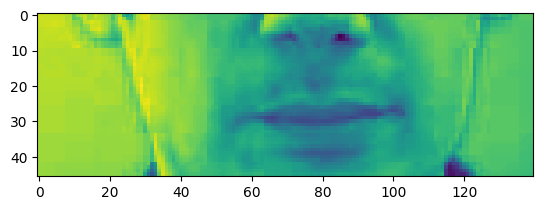

In [91]:
frames, alignments = load_data(tf.convert_to_tensor(path1))
plt.imshow(frames[0])

In [92]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>